In [1]:
import numpy as np
import signac as sg
from itertools import product
from matplotlib import pyplot as plt
from matplotlib import cm, colors

#### Plotting functions

In [2]:
def heatmap(data, row_labels, col_labels, ax, fig,
            xlabel="", ylabel="", title="", cbarlabel="", 
            savefig=False, fn='', path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/',
            **kwargs):
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.8)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, fontsize=15, labelpad=20)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels, fontsize=12)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_title(title, fontsize=20)
    if savefig:
        if fn == '':
            fn = str(int(np.random.sample()*1e5))+'.png'
        fig.savefig(path + fn)

#### Get omega data

In [3]:
project = sg.get_project()
# Read in no cross-diffusion omega data
sd_fn = project.fn('shared_data.h5')
with sg.H5Store(sd_fn).open(mode='r') as sd:
    nocross_omega_sec_mat = np.array(sd['nocross\omega_sec_mat'])
    nocross_omega = float(sd['nocross\omega'])
omega_mat = np.zeros((3,3))
omega_sec_mats = []
for job in project:
    omega_sum = 0.0
    omega_sec_mat = np.zeros((2,2,4))
    with job.data:
        # Loop over parameter space sections 
        for phi_lims in product(range(2), range(2), range(4)):
            conds = []
            for i, lim in enumerate(phi_lims):
                conds.append(np.array(job.data['phi_'+str(i+1)]) > lim*np.pi/2)
                conds.append(np.array(job.data['phi_'+str(i+1)]) < (lim + 1)*np.pi/2)
            cond = np.all(conds, axis=0)
            omega_integrand_sec = np.array(job.data['omega_integrand/wav'])[cond] + np.array(job.data['omega_integrand/st'])[cond]
            i, j, k = phi_lims
            omega_sec_mat[i, j, k] = sum(omega_integrand_sec) / sum(cond)
            omega_sum += sum(omega_integrand_sec)
        omega_sec_mats.append(omega_sec_mat)
        i, j = job.sp['C_offdiag']
        omega_mat[i, j] = (omega_sum / len(job.data['phi_1'])) #- nocross_omega

#### Plot

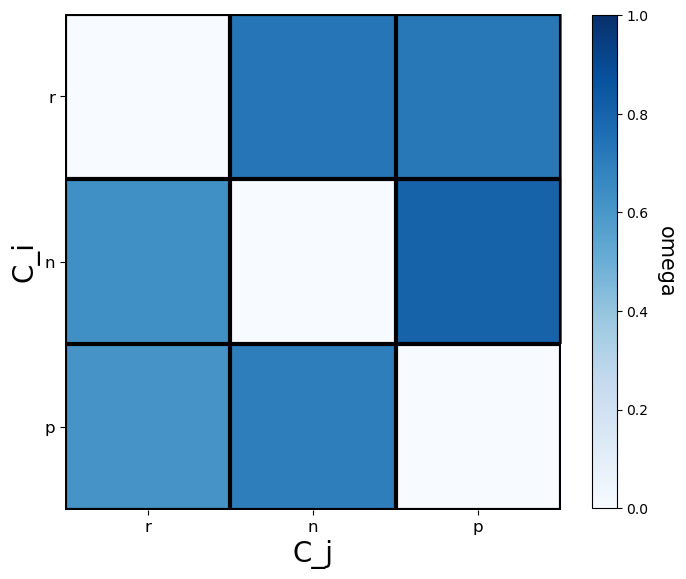

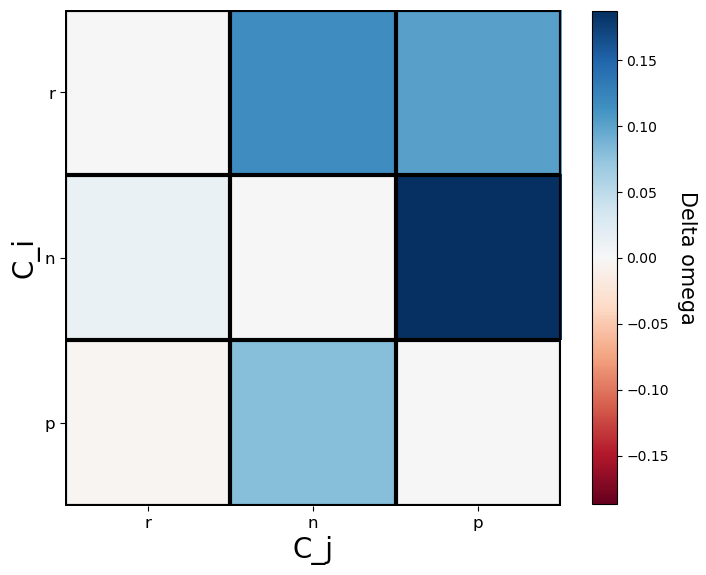

In [113]:
fig, ax = plt.subplots(figsize=(8, 8))
norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
heatmap(omega_mat, ['r','n','p'], ['r','n','p'], fig=fig, ax=ax, cmap="Blues", norm=norm,
        cbarlabel="omega", xlabel='C_j', ylabel='C_i',
        savefig=True, fn='omega_per_Cij.png')

fig, ax = plt.subplots(figsize=(8, 8))
omega_diff_mat = omega_mat - nocross_omega*(-1.*(np.eye(3)-1))
bound = max([abs(np.min(omega_diff_mat)),abs(np.max(omega_diff_mat))])
norm = colors.TwoSlopeNorm(vmin=-bound, vcenter=0, vmax=bound)
heatmap(omega_diff_mat, ['r','n','p'], ['r','n','p'], fig=fig, ax=ax, 
        cbarlabel="Delta omega", xlabel='C_j', ylabel='C_i', 
        cmap="RdBu", savefig=True, fn='omega_diff_per_Cij.png', norm=norm)

In [10]:
schema = project.detect_schema()
C_offdiags = list(schema['C_offdiag'][tuple])
C_offdiags

[(0, 1), (1, 2), (2, 1), (2, 0), (0, 2), (1, 0)]

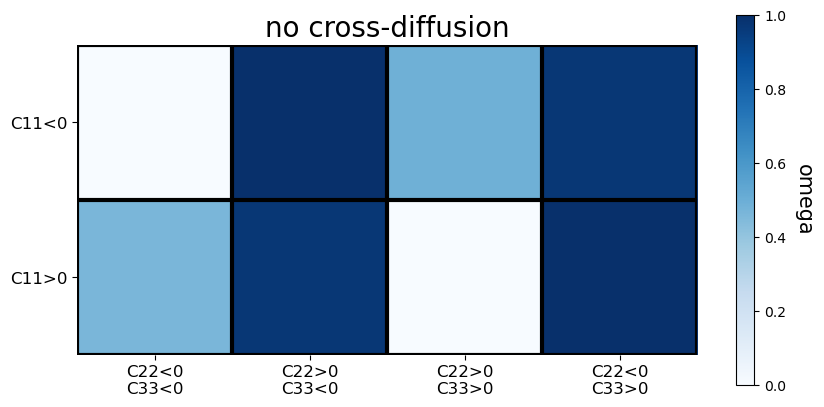

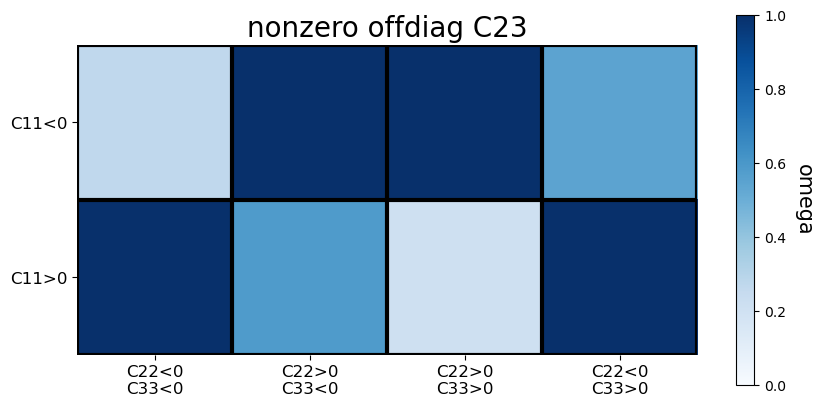

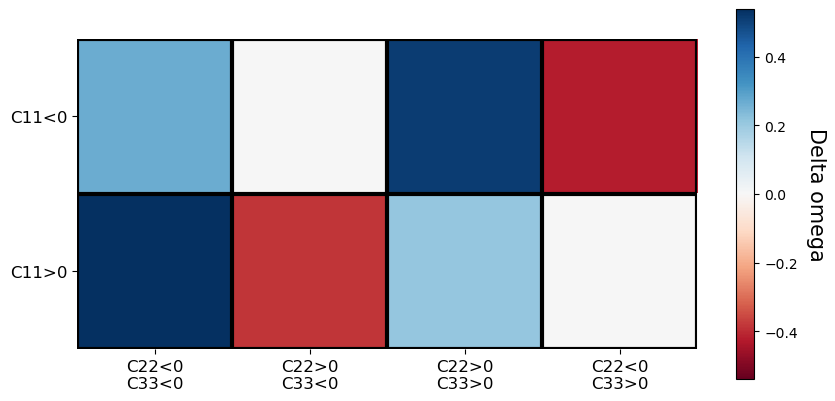

In [21]:
# xticks = ['(0,pi/2)','(pi/2,pi)','(pi,3pi/2)','(3pi/2,2pi)']
# yticks = ['(0,pi/2)','(pi/2,pi)']
xticks = ['C22<0\nC33<0','C22>0\nC33<0','C22>0\nC33>0','C22<0\nC33>0']
yticks = ['C11<0','C11>0']

fig, ax = plt.subplots(figsize=(10, 6))
norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
cmap = 'Blues'
heatmap(nocross_omega_sec_mat, yticks, xticks, 
        fig=fig, ax=ax, cbarlabel="omega", cmap="Blues", norm=norm,
        title="no cross-diffusion", savefig=False, fn='omega_nocross.png')

# for i in range(6):
for i in ([1]):
    fig, ax = plt.subplots(figsize=(10, 6))
    mean_omega_sec_mat = np.mean(omega_sec_mats[i], axis=0)
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
    cmap = 'Blues'
    Cij = "C{}{}".format(str(C_offdiags[i][0]+1), str(C_offdiags[i][1]+1))
    heatmap(mean_omega_sec_mat, yticks, xticks, 
            fig=fig, ax=ax, cbarlabel="omega", cmap="Blues", norm=norm, 
            title="nonzero offdiag "+Cij, 
            savefig=True, fn='omega_{}.png'.format(Cij))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    omega_diff_sec_mat = np.mean(omega_sec_mats[i] - nocross_omega_sec_mat, axis=0)
    bound = max([abs(np.min(omega_diff_sec_mat)),abs(np.max(omega_diff_sec_mat))])
    if np.min(omega_diff_sec_mat) < 0:
        norm = colors.TwoSlopeNorm(vmin=-bound, vcenter=0, vmax=bound)
        cmap = 'RdBu'  
    else:
        norm = colors.TwoSlopeNorm(vmin=0, vcenter=bound/2, vmax=bound)
        cmap = 'Blues'
    heatmap(omega_diff_sec_mat, yticks, xticks, 
            fig=fig, ax=ax, cbarlabel="Delta omega", cmap=cmap, norm=norm,
            title="", savefig=False, fn='Deltaomega_C12.png')

['C11', 'C22', 'C23', 'C33', 'kappa_cs', 'omega_integrand', 'phi_1', 'phi_2', 'phi_3']


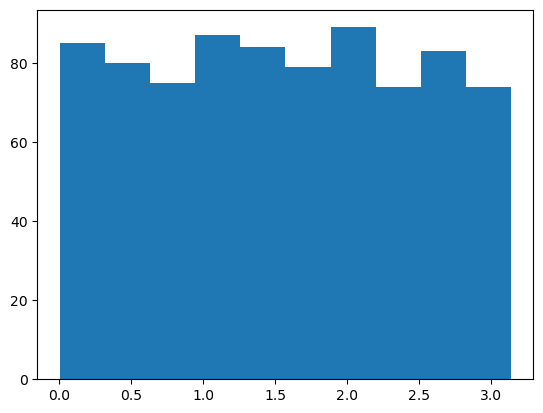

In [ ]:
# Histogram to make sure that data is where I think it is
with job.data as data:
    cond = np.array(data['C33']) < 0
    test = np.array(data['phi_3'])[cond]
    plt.hist(test)